#CheXpert

In [0]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize
import torch.backends.cudnn as cudnn
import torchvision
import torch.optim as optim
from PIL import Image
from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_gpu = torch.cuda.is_available()

Mount google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
baseFolder  = "/drive/My Drive/CheXpert Dataset/CheXpert-v1.0-small/"

In [0]:
#Utility functions for cleaning the data

def cleanLabel(x):
    
    labelCount = 0    
    if x.Pleural_Effusion == 1:
        labelCount += 1
    if x.Edema == 1:
        labelCount += 1
    if x.Cardiomegaly ==1:
        labelCount += 1
    if x.Pneumonia == 1:
        labelCount += 1
    return labelCount
    
    

def getLabel(x):
    
    if x.Pleural_Effusion ==1:
        return "Pleural_Effusion"
    elif x.Edema == 1:
        return "Edema"
    elif x.Cardiomegaly==1:
        return "Cardiomegaly"
    elif x.Pneumonia == 1:
        return "Pneumonia"
    else:
        return "None"

In [0]:
#Try with both pretrained and non pretrained weights
preTrained = True     

#Trying this on all 14 classes now instead of 4
classCount = 14                   

# Training settings: batch size, maximum number of epochs
batchSize = 16
maxEpoch = 3

#Dataframe columns
cols = ['Path',
 'Sex',
 'Age',
 'View',
 'AP/PA',
 'No_Finding',
 'Enlarged_Cardiomediastinum',
 'Cardiomegaly',
 'Lung_Opacity',
 'Lung_Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Effusion',
 'Pleural_Other',
 'Fracture',
 'Support_Devices']

pathFileTrain = baseFolder + 'train.csv'
pathFileValid = baseFolder + 'valid.csv'

## Dataloader for using 14 classes

Need to change uncertain labels (Trying 1s policy)


In [0]:
#For 4 classes
labelMap = {"Pleural_Effusion":0, "Edema":1,"Cardiomegaly":2,"Pneumonia":3}

def getLabelDf(x):
    x = x[36:]          #To account for the extra "././" added before the Path variable
    x = df.loc[df.Path == x] 
    return labelMap[x.label.values[0]]

In [0]:
class LungDataset(Dataset):
    def __init__(self, baseFolder, file, transform=None, type="All"):
        image_files = []
        labels = []

        with open(file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                #print(line[0])
                image_file= line[0]
                if((type=="All") or (type=="Frontal" and image_file.endswith('frontal.jpg')) or (type == "Lateral" and image_file.endswith('lateral.jpg'))):
                    #Create a 14 class label with 0s and 1s for the corresponding pathologies
                    label = line[5:]

                    #Handling uncertainity
                    # TODO: Also try 0s for Us
                    for i in range(14):
                        if label[i]:
                            a = float(label[i])
                            if a == 1:
                                label[i] = 1
                            elif a == -1:
                                label[i] = 1
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0       
                    #TODO: Change when running locally!    
                    image_files.append(baseFolder + image_file)
                    labels.append(label)
                    
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        location = self.image_files[index]
        image = Image.open(location).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_files)

In [0]:
input_size = 256
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ColorJitter(brightness=.05, hue=.05, saturation=.05),
            transformList.append(transforms.RandomHorizontalFlip()),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:

trainDataset = LungDataset('',pathFileTrain, input_transforms)  
validationDataset = LungDataset('',pathFileValid, input_transforms)  

In [0]:
e = next(iter(trainDataset))
e[0].size()

torch.Size([3, 256, 256])

In [0]:
#Chose batch size of 8 cause of memory limitations on the local GPU
train_data_loader = DataLoader(trainDataset, batch_size= 8, shuffle = True)
validation_loader = DataLoader(validationDataset, batch_size= 8, shuffle = True)

In [0]:
for image, label in train_data_loader:
    print(label)
    
    break;

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


## Logger

In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://6a5b48eb.ngrok.io


In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
logger = Logger('./logs')


## DenseNet

In [0]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [0]:
device = torch.device('cuda:0')

input_size = 196608

#Densenet 121 with sigmoid at the last layer 14 outputs
#Each output respresents the probability of occurence of the pathology
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.densenet = torchvision.models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Sequential(
            nn.Linear(self.densenet.classifier.in_features, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.densenet(x)
        return x


In [0]:
#Training loop
def train(net, optimizer, criterion, train_loader, test_loader, epochs, size, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            #print(loss)
            optimizer.step()
            _, prediction = torch.max(outputs,1)
            
            overall_step+=1
            if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item()}

              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
    

In [0]:
num_classes = 14
learning_rate = 0.00003
model = Net(num_classes).cuda()
criterion = torch.nn.BCELoss(size_average = True)
optimizer = torch.optim.Adam (model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
epochs = 5


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/dewang/.torch/models/densenet121-a639ec97.pth
32342954it [00:14, 2157640.47it/s]


In [0]:
train(model, optimizer, criterion, train_data_loader, validation_loader, epochs, input_size , 'densenet-14c', True)

Epoch [1/5], Step [100/27927], Loss: 0.4983
Epoch [1/5], Step [200/27927], Loss: 0.4269
Epoch [1/5], Step [300/27927], Loss: 0.4606
Epoch [1/5], Step [400/27927], Loss: 0.3965
Epoch [1/5], Step [500/27927], Loss: 0.3166
Epoch [1/5], Step [600/27927], Loss: 0.3528
Epoch [1/5], Step [700/27927], Loss: 0.3877
Epoch [1/5], Step [800/27927], Loss: 0.4342
Epoch [1/5], Step [900/27927], Loss: 0.4098
Epoch [1/5], Step [1000/27927], Loss: 0.3241
Epoch [1/5], Step [1100/27927], Loss: 0.3313
Epoch [1/5], Step [1200/27927], Loss: 0.4089
Epoch [1/5], Step [1300/27927], Loss: 0.4090
Epoch [1/5], Step [1400/27927], Loss: 0.3796
Epoch [1/5], Step [1500/27927], Loss: 0.4991
Epoch [1/5], Step [1600/27927], Loss: 0.3248
Epoch [1/5], Step [1700/27927], Loss: 0.4013
Epoch [1/5], Step [1800/27927], Loss: 0.3884
Epoch [1/5], Step [1900/27927], Loss: 0.3886
Epoch [1/5], Step [2000/27927], Loss: 0.4308
Epoch [1/5], Step [2100/27927], Loss: 0.3928
Epoch [1/5], Step [2200/27927], Loss: 0.3691
Epoch [1/5], Step [

Epoch [1/5], Step [18200/27927], Loss: 0.3109
Epoch [1/5], Step [18300/27927], Loss: 0.3829
Epoch [1/5], Step [18400/27927], Loss: 0.2567
Epoch [1/5], Step [18500/27927], Loss: 0.3947
Epoch [1/5], Step [18600/27927], Loss: 0.3086
Epoch [1/5], Step [18700/27927], Loss: 0.2947
Epoch [1/5], Step [18800/27927], Loss: 0.3856
Epoch [1/5], Step [18900/27927], Loss: 0.3533
Epoch [1/5], Step [19000/27927], Loss: 0.3637
Epoch [1/5], Step [19100/27927], Loss: 0.2556
Epoch [1/5], Step [19200/27927], Loss: 0.3487
Epoch [1/5], Step [19300/27927], Loss: 0.5138
Epoch [1/5], Step [19400/27927], Loss: 0.3538
Epoch [1/5], Step [19500/27927], Loss: 0.3312
Epoch [1/5], Step [19600/27927], Loss: 0.3936
Epoch [1/5], Step [19700/27927], Loss: 0.3416
Epoch [1/5], Step [19800/27927], Loss: 0.3139
Epoch [1/5], Step [19900/27927], Loss: 0.3901
Epoch [1/5], Step [20000/27927], Loss: 0.3917
Epoch [1/5], Step [20100/27927], Loss: 0.3810
Epoch [1/5], Step [20200/27927], Loss: 0.4607
Epoch [1/5], Step [20300/27927], L

Epoch [2/5], Step [8400/27927], Loss: 0.3330
Epoch [2/5], Step [8500/27927], Loss: 0.3789
Epoch [2/5], Step [8600/27927], Loss: 0.3937
Epoch [2/5], Step [8700/27927], Loss: 0.2989
Epoch [2/5], Step [8800/27927], Loss: 0.3306
Epoch [2/5], Step [8900/27927], Loss: 0.3399
Epoch [2/5], Step [9000/27927], Loss: 0.3080
Epoch [2/5], Step [9100/27927], Loss: 0.3501
Epoch [2/5], Step [9200/27927], Loss: 0.3123
Epoch [2/5], Step [9300/27927], Loss: 0.2948
Epoch [2/5], Step [9400/27927], Loss: 0.4675
Epoch [2/5], Step [9500/27927], Loss: 0.2771
Epoch [2/5], Step [9600/27927], Loss: 0.4516
Epoch [2/5], Step [9700/27927], Loss: 0.3193
Epoch [2/5], Step [9800/27927], Loss: 0.3524
Epoch [2/5], Step [9900/27927], Loss: 0.2982
Epoch [2/5], Step [10000/27927], Loss: 0.4222
Epoch [2/5], Step [10100/27927], Loss: 0.3555
Epoch [2/5], Step [10200/27927], Loss: 0.4239
Epoch [2/5], Step [10300/27927], Loss: 0.4482
Epoch [2/5], Step [10400/27927], Loss: 0.2692
Epoch [2/5], Step [10500/27927], Loss: 0.3812
Epoc

Epoch [2/5], Step [26300/27927], Loss: 0.2831
Epoch [2/5], Step [26400/27927], Loss: 0.3660
Epoch [2/5], Step [26500/27927], Loss: 0.3393
Epoch [2/5], Step [26600/27927], Loss: 0.3777
Epoch [2/5], Step [26700/27927], Loss: 0.3646
Epoch [2/5], Step [26800/27927], Loss: 0.3807
Epoch [2/5], Step [26900/27927], Loss: 0.4066
Epoch [2/5], Step [27000/27927], Loss: 0.3903
Epoch [2/5], Step [27100/27927], Loss: 0.3272
Epoch [2/5], Step [27200/27927], Loss: 0.3294
Epoch [2/5], Step [27300/27927], Loss: 0.4711
Epoch [2/5], Step [27400/27927], Loss: 0.4437
Epoch [2/5], Step [27500/27927], Loss: 0.2303
Epoch [2/5], Step [27600/27927], Loss: 0.3592
Epoch [2/5], Step [27700/27927], Loss: 0.3464
Epoch [2/5], Step [27800/27927], Loss: 0.3629
Epoch [2/5], Step [27900/27927], Loss: 0.3783
Epoch [3/5], Step [100/27927], Loss: 0.3040
Epoch [3/5], Step [200/27927], Loss: 0.3773
Epoch [3/5], Step [300/27927], Loss: 0.2377
Epoch [3/5], Step [400/27927], Loss: 0.3801
Epoch [3/5], Step [500/27927], Loss: 0.367

Epoch [3/5], Step [16500/27927], Loss: 0.3291
Epoch [3/5], Step [16600/27927], Loss: 0.3136
Epoch [3/5], Step [16700/27927], Loss: 0.5428
Epoch [3/5], Step [16800/27927], Loss: 0.2320
Epoch [3/5], Step [16900/27927], Loss: 0.3223
Epoch [3/5], Step [17000/27927], Loss: 0.2938
Epoch [3/5], Step [17100/27927], Loss: 0.3004
Epoch [3/5], Step [17200/27927], Loss: 0.3234
Epoch [3/5], Step [17300/27927], Loss: 0.3422
Epoch [3/5], Step [17400/27927], Loss: 0.3687
Epoch [3/5], Step [17500/27927], Loss: 0.2945
Epoch [3/5], Step [17600/27927], Loss: 0.3315
Epoch [3/5], Step [17700/27927], Loss: 0.3233
Epoch [3/5], Step [17800/27927], Loss: 0.3234
Epoch [3/5], Step [17900/27927], Loss: 0.3278
Epoch [3/5], Step [18000/27927], Loss: 0.4121
Epoch [3/5], Step [18100/27927], Loss: 0.3718
Epoch [3/5], Step [18200/27927], Loss: 0.3352
Epoch [3/5], Step [18300/27927], Loss: 0.2658
Epoch [3/5], Step [18400/27927], Loss: 0.3598
Epoch [3/5], Step [18500/27927], Loss: 0.3741
Epoch [3/5], Step [18600/27927], L

Epoch [4/5], Step [6600/27927], Loss: 0.4193
Epoch [4/5], Step [6700/27927], Loss: 0.5120
Epoch [4/5], Step [6800/27927], Loss: 0.3393
Epoch [4/5], Step [6900/27927], Loss: 0.3284
Epoch [4/5], Step [7000/27927], Loss: 0.3594
Epoch [4/5], Step [7100/27927], Loss: 0.3504
Epoch [4/5], Step [7200/27927], Loss: 0.2896
Epoch [4/5], Step [7300/27927], Loss: 0.3686
Epoch [4/5], Step [7400/27927], Loss: 0.4266
Epoch [4/5], Step [7500/27927], Loss: 0.2582
Epoch [4/5], Step [7600/27927], Loss: 0.4178
Epoch [4/5], Step [7700/27927], Loss: 0.2859
Epoch [4/5], Step [7800/27927], Loss: 0.2737
Epoch [4/5], Step [7900/27927], Loss: 0.3889
Epoch [4/5], Step [8000/27927], Loss: 0.4024
Epoch [4/5], Step [8100/27927], Loss: 0.4446
Epoch [4/5], Step [8200/27927], Loss: 0.3448
Epoch [4/5], Step [8300/27927], Loss: 0.3732
Epoch [4/5], Step [8400/27927], Loss: 0.3304
Epoch [4/5], Step [8500/27927], Loss: 0.3265
Epoch [4/5], Step [8600/27927], Loss: 0.3371
Epoch [4/5], Step [8700/27927], Loss: 0.4054
Epoch [4/5

Epoch [4/5], Step [24500/27927], Loss: 0.2528
Epoch [4/5], Step [24600/27927], Loss: 0.4467
Epoch [4/5], Step [24700/27927], Loss: 0.4090
Epoch [4/5], Step [24800/27927], Loss: 0.2678
Epoch [4/5], Step [24900/27927], Loss: 0.4548
Epoch [4/5], Step [25000/27927], Loss: 0.4318
Epoch [4/5], Step [25100/27927], Loss: 0.3225
Epoch [4/5], Step [25200/27927], Loss: 0.2456
Epoch [4/5], Step [25300/27927], Loss: 0.3518
Epoch [4/5], Step [25400/27927], Loss: 0.4351
Epoch [4/5], Step [25500/27927], Loss: 0.2555
Epoch [4/5], Step [25600/27927], Loss: 0.3046
Epoch [4/5], Step [25700/27927], Loss: 0.4074
Epoch [4/5], Step [25800/27927], Loss: 0.2836
Epoch [4/5], Step [25900/27927], Loss: 0.3353
Epoch [4/5], Step [26000/27927], Loss: 0.3445
Epoch [4/5], Step [26100/27927], Loss: 0.3426
Epoch [4/5], Step [26200/27927], Loss: 0.3945
Epoch [4/5], Step [26300/27927], Loss: 0.2425
Epoch [4/5], Step [26400/27927], Loss: 0.3455
Epoch [4/5], Step [26500/27927], Loss: 0.3945
Epoch [4/5], Step [26600/27927], L

Epoch [5/5], Step [14700/27927], Loss: 0.2987
Epoch [5/5], Step [14800/27927], Loss: 0.3046
Epoch [5/5], Step [14900/27927], Loss: 0.2790
Epoch [5/5], Step [15000/27927], Loss: 0.2974
Epoch [5/5], Step [15100/27927], Loss: 0.4103
Epoch [5/5], Step [15200/27927], Loss: 0.3058
Epoch [5/5], Step [15300/27927], Loss: 0.4503
Epoch [5/5], Step [15400/27927], Loss: 0.3490
Epoch [5/5], Step [15500/27927], Loss: 0.3155
Epoch [5/5], Step [15600/27927], Loss: 0.4161
Epoch [5/5], Step [15700/27927], Loss: 0.3414
Epoch [5/5], Step [15800/27927], Loss: 0.3099
Epoch [5/5], Step [15900/27927], Loss: 0.4180
Epoch [5/5], Step [16000/27927], Loss: 0.3432
Epoch [5/5], Step [16100/27927], Loss: 0.3227
Epoch [5/5], Step [16200/27927], Loss: 0.3468
Epoch [5/5], Step [16300/27927], Loss: 0.2838
Epoch [5/5], Step [16400/27927], Loss: 0.3730
Epoch [5/5], Step [16500/27927], Loss: 0.4183
Epoch [5/5], Step [16600/27927], Loss: 0.3286
Epoch [5/5], Step [16700/27927], Loss: 0.3953
Epoch [5/5], Step [16800/27927], L

In [0]:
torch.save(model.state_dict(), 'densenet_5epochs.pt')

In [0]:

#Compute the roc auc score for each class separately
def class_roc_auc(data, predicted, class_count = 14):

    auroc = []

    data_np = data.cpu().numpy()
    data_np_pred = predicted.cpu().numpy()

    for i in range(class_count):
        auroc.append(roc_auc_score(data_np[:, i], data_np_pred[:, i]))
    return auroc



def test(model, test_loader, class_count, class_names):   

   
    out = torch.FloatTensor().cuda()
    out_pred = torch.FloatTensor().cuda()
    model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            target = label.cuda()
            out = torch.cat((out, target), 0).cuda()
            outV = model(image)
            out_pred = torch.cat((out_pred, outV), 0)
    auc_roc_class = class_roc_auc(out, out_pred, class_count)
    aurocMean = np.array(auc_roc_class).mean()

    print ('AUROC mean ', aurocMean)

    for i in range (0, len(auc_roc_class)):
        print (class_names[i], ' ', auc_roc_class[i])

    return out, out_pred

In [0]:

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
out, out_pred = test(model, validation_loader, 14, class_names)

AUROC mean  0.7663288558407481
No Finding   0.8681525241675618
Enlarged Cardiomediastinum   0.49812844036697246
Cardiomegaly   0.8430191353649894
Lung Opacity   0.9155643738977073
Lung Lesion   0.296137339055794
Edema   0.9074661963550853
Consolidation   0.8679330619629128
Pneumonia   0.7378318584070797
Atelectasis   0.807711038961039
Pneumothorax   0.8246681415929203
Pleural Effusion   0.9244793994101348
Pleural Other   0.5321888412017167
Fracture   0.9389947751858121


In [0]:
print(out)
print(out_pred)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[0.2642, 0.1065, 0.0790,  ..., 0.0520, 0.0627, 0.0567],
        [0.0396, 0.0745, 0.1766,  ..., 0.0112, 0.0348, 0.0658],
        [0.0361, 0.0661, 0.0927,  ..., 0.0050, 0.0098, 0.8275],
        ...,
        [0.0966, 0.0449, 0.1127,  ..., 0.0057, 0.1706, 0.3420],
        [0.2758, 0.0385, 0.0281,  ..., 0.0034, 0.0021, 0.9555],
        [0.0960, 0.0948, 0.0635,  ..., 0.0573, 0.1487, 0.0328]],
       device='cuda:0')


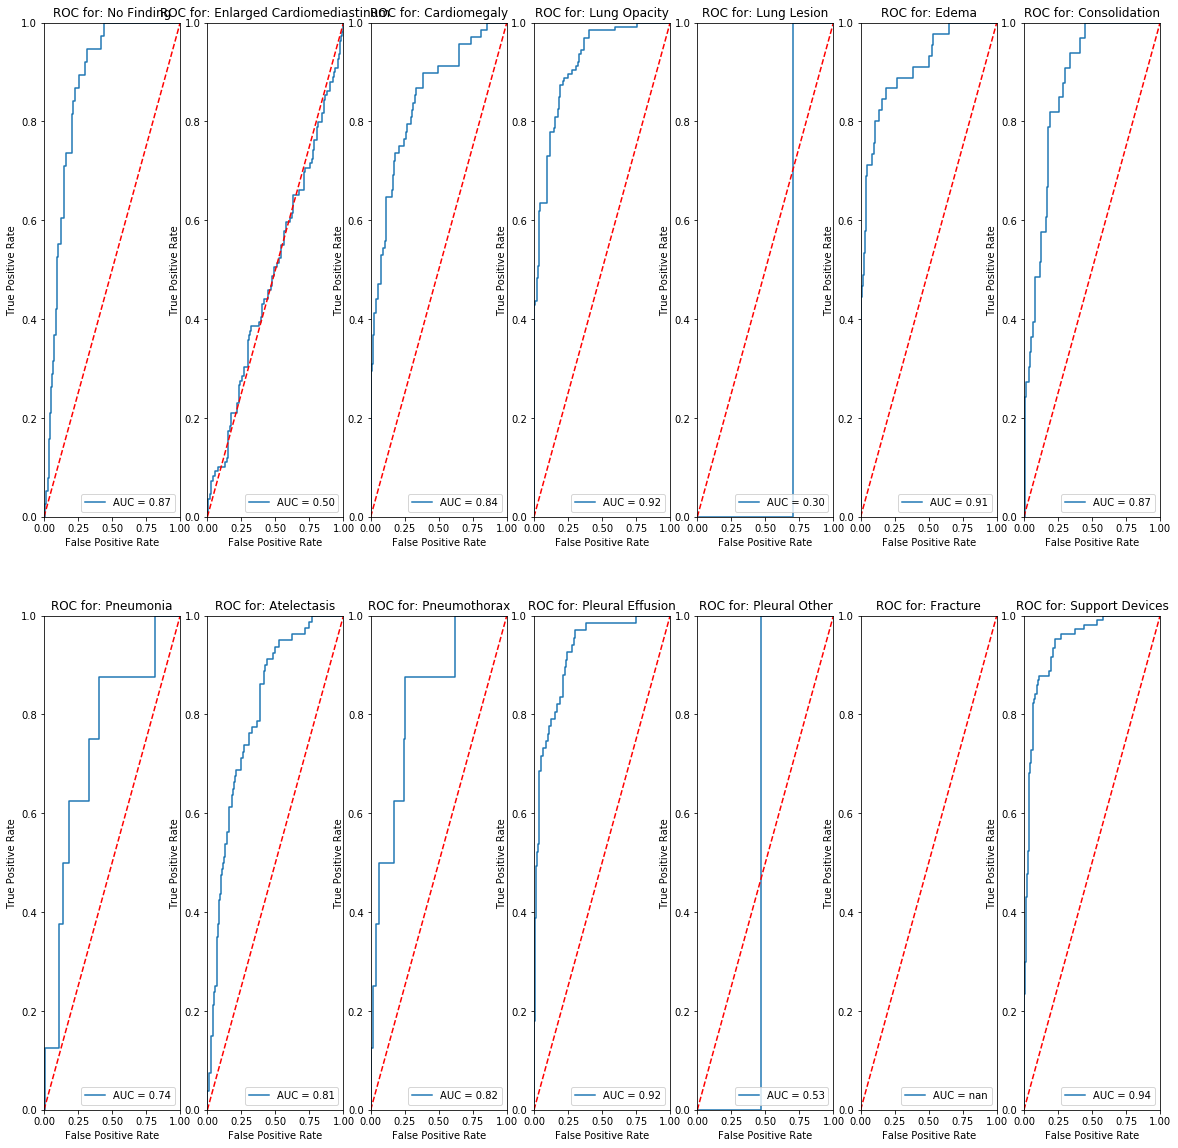

In [0]:
for i in range(14):
    fpr, tpr, threshold = metrics.roc_curve(out.cpu()[:,i], out_pred.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


plt.show()

### Load saved model and test

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
